# 1. Random Forest

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

In [2]:
data=pd.read_csv('processed_data.csv')
data.head()

,Burden(m),Hole_Spacing(m),Bench_Height(m),Drilling_Length(m),PF (kg/t),Charge_Volume(kg),Fragmentation_Effect (%),UCS(MPa),BTS(MPa),Crack_Density(cracks/m),Point_Load(MPa),Density(kg/m3),RQD,Maximum_Azimuth_Angle (°),Average_Azimuth_Angle(°),Velocity_(m/s),MI_Velocity(m/s)
0,2.0,2,10,10.0,0.16,90.5,11.0,121.8,6.0,0.48,904.76,2377.0,91.0,18.0,11.0,18.4,25.1
1,1.5,2,10,9.0,0.21,80.5,83.0,223.1,10.5,0.43,904.76,2492.0,85.0,17.0,12.0,25.1,31.9
2,2.5,2,10,10.0,0.13,125.5,31.0,207.3,9.5,0.40,904.76,2327.0,95.0,24.0,14.0,11.4,14.5
3,1.5,2,10,9.0,0.21,72.5,34.0,42.4,4.4,1.08,904.76,1912.0,79.0,31.0,18.0,16.3,31.1
4,1.5,2,10,11.0,0.24,184.5,0.0,190.9,11.7,0.47,904.76,2427.0,95.0,40.0,31.0,18.1,19.6


In [3]:
data.shape

(89, 17)

In [4]:
correlation_matrix = data.corr()
correlation_with_target = data.corr()[' MI_Velocity(m/s) '].abs().sort_values(ascending=False)
print(correlation_with_target)

 MI_Velocity(m/s)              1.000000
 Velocity_(m/s)                0.473155
 Crack_Density(cracks/m)       0.272337
 Density(kg/m3)                0.234902
 PF (kg/t)                     0.202284
 Average_Azimuth_Angle(°)      0.188059
 Burden(m)                     0.128290
 Charge_Volume(kg)             0.121143
 Point_Load(MPa)               0.113200
 BTS(MPa)                      0.104854
 Maximum_Azimuth_Angle (°)     0.089877
 RQD                           0.080458
 Drilling_Length(m)            0.011215
 Fragmentation_Effect (%)      0.008438
 UCS(MPa)                      0.001791
 Hole_Spacing(m)                    NaN
 Bench_Height(m)                    NaN
Name:  MI_Velocity(m/s) , dtype: float64


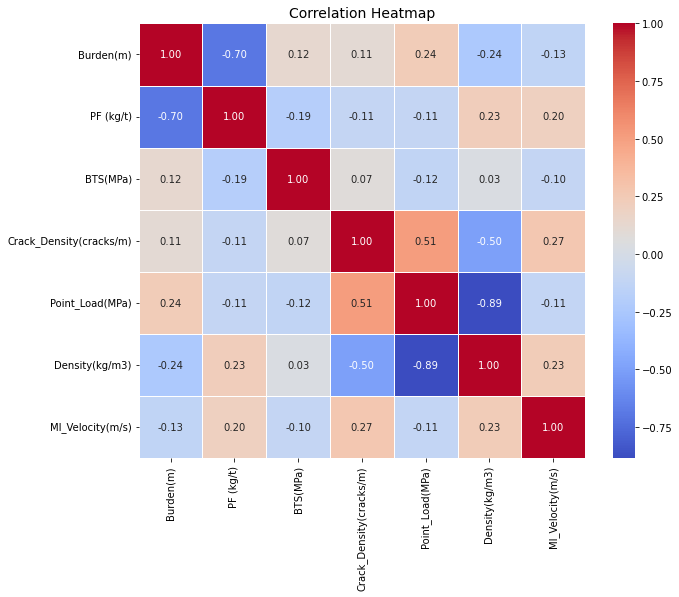

In [5]:
data.columns = data.columns.str.strip()
correlation_data = data.drop(columns=['Hole_Spacing(m)', 'Bench_Height(m)',
                                      'Fragmentation_Effect (%)','UCS(MPa)',
                                      'Drilling_Length(m)','Charge_Volume(kg)',
                                     'RQD','Maximum_Azimuth_Angle (°)',
                                     'Velocity_(m/s)','Average_Azimuth_Angle(°)'])

correlation_matrix = correlation_data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap',fontsize=14)
plt.show()


In [6]:
X = data.drop('MI_Velocity(m/s)', axis=1)
y = data['MI_Velocity(m/s)']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [9]:
rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestRegressor(random_state=42))
])

rf_params = {
    'model__n_estimators': randint(50, 500),
    'model__max_depth': [None, 10, 20, 30],
    'model__min_samples_split': randint(2, 20),
    'model__min_samples_leaf': randint(1, 20),
    'model__max_features': ['auto', 'sqrt', 'log2', 1.0]  # Set 'max_features' to 1.0 explicitly.
}

rf_random_search = RandomizedSearchCV(rf_pipeline, rf_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, n_iter=50, random_state=42)
rf_random_search.fit(X_train_scaled, y_train)

best_rf_model = rf_random_search.best_estimator_

best_rf_model.fit(X_train_scaled, y_train)

y_pred_rf = best_rf_model.predict(X_test_scaled)

C:\Users\Rawnaq\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\Rawnaq\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


In [10]:
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
mape_rf = np.mean(np.abs((y_test - y_pred_rf) / y_test)) * 100

print("Random Forest Regression Model:")
print("Mean Squared Error (RMSE):", rmse_rf)
print("Mean Absolute Error:", mae_rf)
print("R-squared:", r2_rf)
print("Mean Absolute Percentage Error (MAPE):", mape_rf)

Random Forest Regression Model:
Mean Squared Error (RMSE): 1.016032571871702
Mean Absolute Error: 0.577585828470169
R-squared: 0.9751731781398653
Mean Absolute Percentage Error (MAPE): 3.559541980773355


In [11]:
y_test_series = pd.Series(y_test.values, name='Actual MI Velocity (m/s)')
y_pred_series = pd.Series(y_pred_rf, name='Predicted MI Velocity (m/s)')

results_df = pd.concat([y_test_series, y_pred_series], axis=1)

print(results_df)

    Actual MI Velocity (m/s)  Predicted MI Velocity (m/s)
0                      15.60                    15.879954
1                       7.40                     7.883938
2                      10.00                    10.186040
3                      21.00                    20.433749
4                      24.30                    24.576292
5                      25.10                    21.754500
6                       4.10                     4.099371
7                      20.40                    18.061055
8                      12.40                    11.984923
9                       7.40                     8.013106
10                     19.60                    19.845537
11                     21.00                    20.491414
12                     13.67                    13.578167
13                      4.10                     4.099371
14                     15.60                    15.882263
15                     10.00                    10.270178
16            

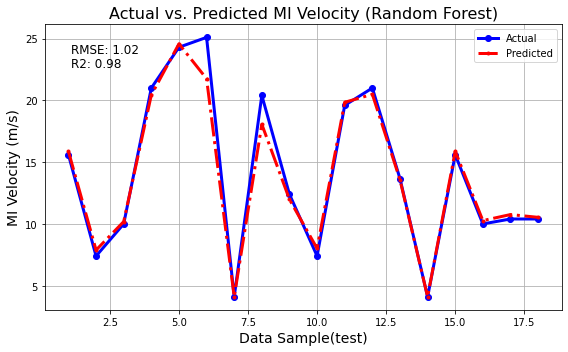

In [12]:
y_pred = y_pred_rf
data_points = np.arange(1, len(y_test) + 1)

plt.figure(figsize=(8, 5))
plt.plot(data_points, y_test.values, color='b', linewidth=3, linestyle='-', marker='o', label='Actual')
plt.plot(data_points, y_pred, color='r', marker='.', linewidth=3, linestyle='-.', label='Predicted')
plt.xlabel('Data Sample(test)',fontsize=14)
plt.ylabel('MI Velocity (m/s)',fontsize=14)

rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred))
r2_rf = r2_score(y_test, y_pred)

plt.text(0.05, 0.85, f'R2: {r2_rf:.2f}', transform=plt.gca().transAxes, fontsize=12, color='black')
plt.text(0.05, 0.9, f'RMSE: {rmse_rf:.2f}', transform=plt.gca().transAxes, fontsize=12, color='black')

plt.title('Actual vs. Predicted MI Velocity (Random Forest)',fontsize=16)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


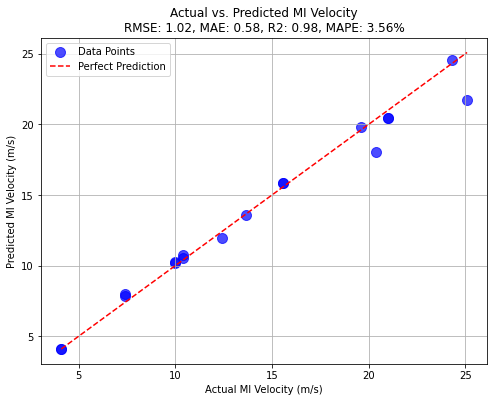

In [13]:
y_pred = y_pred_rf

rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred))
mae_rf = mean_absolute_error(y_test, y_pred)
r2_rf = r2_score(y_test, y_pred)
mape_rf = np.mean(np.abs((y_test - y_pred) / y_test)) * 100


plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='b', alpha=0.7, label='Data Points',s=100)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', label='Perfect Prediction')
plt.xlabel('Actual MI Velocity (m/s)')
plt.ylabel('Predicted MI Velocity (m/s)')
plt.title(f'Actual vs. Predicted MI Velocity\nRMSE: {rmse_rf:.2f}, MAE: {mae_rf:.2f}, R2: {r2_rf:.2f}, MAPE: {mape_rf:.2f}%')
plt.legend()
plt.grid(True)
plt.show()
